# ZOD Dataset Exploration - Camera-Specific Pedestrian Prediction



In [1]:
from pathlib import Path # for file path operations
import os # for file path operations
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
import torchvision
from collections import Counter


In [2]:
DATA_ROOT = Path("/home/edgelab/zod_dino_data")
TRAIN_ROOT = DATA_ROOT / "train2017" # 100k frames training set
VAL_ROOT = DATA_ROOT / "val2017" # 100k frames validation set
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("Top-level contents:")
for p in sorted(DATA_ROOT.iterdir()):
    print(" -", p.name)



DATA_ROOT exists: True
Top-level contents:
 - annotations
 - train2017
 - val2017


## Dataset location and on-disk structure (local VM)

**Dataset root:** `/home/edgelab/zod_dino_data`

Top-level folders:
- `train2017/`
- `val2017/`
- `annotations/`

### Frame folder structure
Inside `train2017/` there are ~100,000 frame folders named:
`000000/`, `000001/`, `000002/`, ...

Each frame folder contains:
- `annotations/` — per-frame labels (e.g., 2D/3D boxes, segmentation, etc.)
- `camera_front_blur/` — anonymized camera image (blur)
- `camera_front_dnat/` — anonymized camera image (DNAT)
- `lidar_velodyne/` — LiDAR data for the keyframe

This exploration notebook focuses on **vision-only** using the front camera images
(`camera_front_blur` / `camera_front_dnat`) and the corresponding object labels
in `annotations/`, with emphasis on **pedestrians** and condition metadata.


In [18]:

frame_id = "000000" #first frame

#first_frame_dir is a path object representing the path to the frame folder:
                        #/home/edgelab/zod_dino_data/train2017/000000
first_frame_dir = TRAIN_ROOT / frame_id
print("Frame dir exists:", first_frame_dir.exists()) 

# list contents
print("Frame contents:", [p.name for p in first_frame_dir.iterdir()])

# find an image in blur folder
# glob means: find files matching a pattern
blur_dir = first_frame_dir / "camera_front_blur"
blur_img_files = sorted(list(blur_dir.glob("*.jpg")) + list(blur_dir.glob("*.png")))
print("First blur image file path(000000):", blur_img_files[0] if blur_img_files else None)

# Note: the dnat folder contains two images and one is resized version of the other 
# find an image in dnat folder
dnat_dir = first_frame_dir / "camera_front_dnat"
dnat_img_files = sorted(list(dnat_dir.glob("*.jpg")) )

for img_file in dnat_img_files:
    if "resized" in img_file.name:
        resized_dnat_img = img_file
    else:
        dnat_img_original = img_file
print("dnat_img_original_path:", dnat_img_original)
print("resized_dnat_img_path:", resized_dnat_img)




Frame dir exists: True
Frame contents: ['camera_front_dnat', 'camera_front_blur', 'lidar_velodyne', 'calibration.json', 'ego_motion.json', 'metadata.json', 'info.json', 'annotations', 'oxts.hdf5']
First blur image file path(000000): /home/edgelab/zod_dino_data/train2017/000000/camera_front_blur/000000_india_2021-04-19T10:23:10.444124Z.jpg
dnat_img_original_path: /home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg
resized_dnat_img_path: /home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z_resized.jpg


Image path: /home/edgelab/zod_dino_data/train2017/000000/camera_front_blur/000000_india_2021-04-19T10:23:10.444124Z.jpg


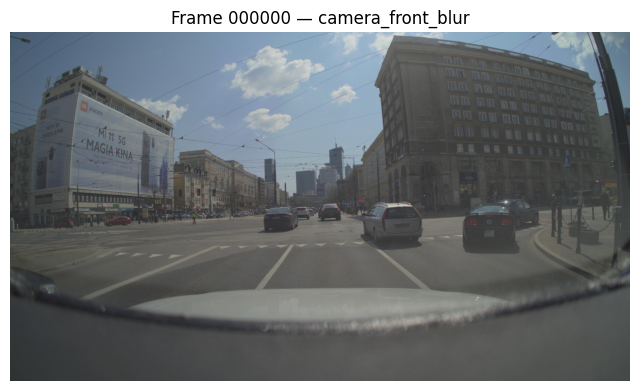

In [4]:
blur_img_path = blur_img_files[0]
print("Image path:", blur_img_path)
blur_img = Image.open(blur_img_path)

plt.figure(figsize=(8, 5))
plt.imshow(blur_img)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_blur")
plt.show()

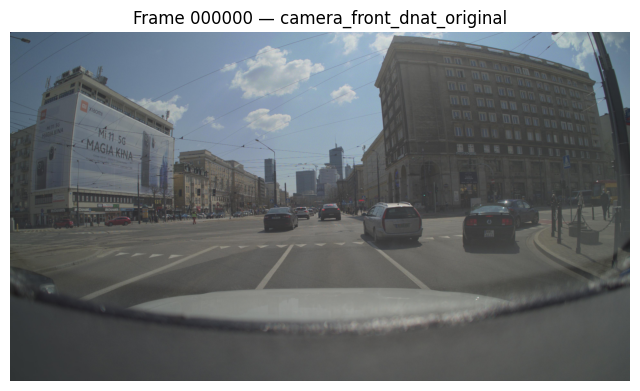

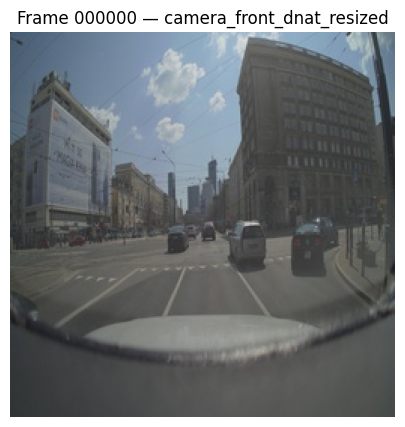

In [5]:
#dnat images (both resized and original)

# Load the original dnat image
dnat_img_original_loaded = Image.open(dnat_img_original)
dnat_img_resized_loaded = Image.open(resized_dnat_img)

plt.figure(figsize=(8, 5))
plt.imshow(dnat_img_original_loaded)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat_original")

plt.figure(figsize=(8, 5))
plt.imshow(dnat_img_resized_loaded)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat_resized")

plt.show()




We use the full-resolution DNAT images for all experiments, as resized images reduce spatial detail and undermine long-range pedestrian perception, which is a core challenge in ZOD.


## Next we analyze frame-specific json files:

In [ ]:

def read_json(path: Path):
    """
    Read a JSON file from disk and return it as a Python object.
    Parameters:
    - path: Path object pointing to a .json file
    Returns:
    - A Python dictionary or list (depending on the JSON content)
    """
    # first we open the file in read mode
    with open(path, "r") as file:

        # json.load reads JSON-formatted text from the file object 'file'
        # and converts it into native Python objects (dicts, lists, etc.)
        data = json.load(file)

    return data

# Read metadata describing environment conditions
metadata = read_json(first_frame_dir / "metadata.json")
#print(metadata)

# Read general info about the frame
info = read_json(first_frame_dir / "info.json")
#print(info)

print("metadata.json 000000 (keys: values)")
for k in metadata.keys():
    print(" -", k + ":", metadata[k])

metadata.json 000000 (keys: values)
 - frame_id: 000000
 - time: 2021-04-19T10:23:10.444124Z
 - country_code: PL
 - scraped_weather: partly-cloudy-day
 - collection_car: india
 - road_type: city
 - road_condition: normal
 - time_of_day: day
 - num_lane_instances: 21
 - num_vehicles: 36
 - num_vulnerable_vehicles: 5
 - num_pedestrians: 40
 - num_traffic_lights: 37
 - num_traffic_signs: 35
 - longitude: 20.993243252850032
 - latitude: 52.24205173254378
 - solar_angle_elevation: 49.17233721956617


In [7]:
print("\ninfo.json keys: values")
for k in info.keys():
    print(" -", k + ":", info[k])


info.json keys: values
 - id: 000000
 - start_time: 2021-04-19T10:23:09.306996Z
 - end_time: 2021-04-19T10:23:11.526356Z
 - keyframe_time: 2021-04-19T10:23:10.444124Z
 - calibration_path: single_frames/000000/calibration.json
 - ego_motion_path: single_frames/000000/ego_motion.json
 - metadata_path: single_frames/000000/metadata.json
 - oxts_path: single_frames/000000/oxts.hdf5
 - vehicle_data_path: None
 - annotations: {'object_detection': {'filepath': 'single_frames/000000/annotations/object_detection.json', 'project': 'object_detection'}, 'lane_markings': {'filepath': 'single_frames/000000/annotations/lane_markings.json', 'project': 'lane_markings'}, 'traffic_signs': {'filepath': 'single_frames/000000/annotations/traffic_signs.json', 'project': 'traffic_signs'}, 'road_condition': {'filepath': 'single_frames/000000/annotations/road_condition.json', 'project': 'road_condition'}}
 - camera_frames: {'front_blur': [{'filepath': 'single_frames/000000/camera_front_blur/000000_india_2021-0

## info.json (frame index file)

### Frame timing
- start_time
- end_time
- keyframe_time  
  (timestamp of the annotated camera image)

### Paths to associated data
- calibration_path
- ego_motion_path
- metadata_path
- oxts_path

### Annotations
Each annotation is referenced via a relative filepath under:
single_frames/000000/annotations/

- Object detection
- Lane markings
- Traffic signs
- Road condition


### Camera frames
- front_blur: one annotated RGB image
- front_dnat: one annotated RGB image  

Both camera images:
- correspond to the same keyframe timestamp
- have the same resolution

### LiDAR frames
- Sequence of Velodyne LiDAR scans at ~10 Hz
- Covers approximately ±1 second around the keyframe
- Stored as .npy point clouds
- All scans marked is_compensated: False


## metadata.json (scene-level metadata)

### Geography
- Country: PL
- Latitude / Longitude provided

### Environment
- Weather: partly-cloudy-day
- Time of day: day
- Road type: city
- Road condition: normal
- Solar elevation angle available

### Object counts (per keyframe)
- Vehicles: 36
- Pedestrians: 40
- Vulnerable vehicles: 5
- Traffic lights: 37
- Traffic signs: 35
- Lane instances: 21

These counts serve as a consistency check against annotation files.


# object_detection.json

In [ ]:
# Object detection annotations live inside the frame folder
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"

print("Object detection path:", obj_det_path)
print("Exists:", obj_det_path.exists())

# Reuse our existing helper (no need to re-write open/json.load every time)
obj_det = read_json(obj_det_path)

# type and size of obj_det contents
print("Type of obj_det:", type(obj_det))
print("Number of objects in this frame:", len(obj_det))

# first annotation object 
first_obj = obj_det[0]
print("Type of one object:", type(first_obj))
print("Keys in one object annotation:", list(first_obj.keys()))

#HENCE, WE OBSERVE THAT WE HAVE A LIST OF DICTIONARIES, containing the annotations for each object in the frame




Object detection path: /home/edgelab/zod_dino_data/train2017/000000/annotations/object_detection.json
Exists: True
Type of obj_det: <class 'list'>
Number of objects in this frame: 281
Type of one object: <class 'dict'>
Keys in one object annotation: ['geometry', 'properties']


In [9]:
print(first_obj.keys())
print(first_obj["geometry"])
print(first_obj["properties"])

# Each element in obj_det is one annotated object (dict with keys: "geometry", "properties")

dict_keys(['geometry', 'properties'])
{'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}
{'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}


In [10]:
# Each element in obj_det is one annotated object (dict with keys: "geometry", "properties")

classes_in_frame = set({obj["properties"]["class"] for obj in obj_det})

# initialize dict to count per class
count_per_class = {c: 0 for c in classes_in_frame}

for obj in obj_det:
    count_per_class[obj["properties"]["class"]] += 1

print(f"Number of unique classes in frame {frame_id}: {len(classes_in_frame)}")
for c, count in count_per_class.items():
    print(" -", c + ":", count)


print("Number of annotated objects in this frame:", len(obj_det))








Number of unique classes in frame 000000: 7
 - TrafficSign: 35
 - PoleObject: 49
 - Vehicle: 46
 - VulnerableVehicle: 5
 - Pedestrian: 57
 - TrafficGuide: 52
 - TrafficSignal: 37
Number of annotated objects in this frame: 281


We have a mismatch ---- in metadata we see num_pedestrians = 40, as opposed to 57 in annotations. 


In [11]:
# Helper: identify if an object is a pedestrian
def is_pedestrian(obj):
    return obj["properties"].get("class") == "Pedestrian"

# Pull all pedestrians in this frame
peds = [obj for obj in obj_det if is_pedestrian(obj)]
print("Pedestrians (raw from object_detection.json):", len(peds))

peds_not_unclear = [obj for obj in peds if not obj["properties"].get("unclear", False)]
print("Pedestrians with unclear == False:", len(peds_not_unclear))

# Occlusion ratio distribution (how many None/Medium/Heavy)
occ_counts = Counter([obj["properties"].get("occlusion_ratio") for obj in peds])
print("Pedestrian occlusion_ratio counts:", dict(occ_counts))


Pedestrians (raw from object_detection.json): 57
Pedestrians with unclear == False: 40
Pedestrian occlusion_ratio counts: {'VeryHeavy': 3, 'Light': 18, 'Heavy': 9, 'Medium': 5, None: 17, 'None': 5}


#### This means that metadata is only counting pedestrians with properties["unclear"] == False, wheras annotations coutns all pedestrians regardless of the "unclear" label. "unclear" means that the annotator isn’t confident / it’s ambiguous  ie low quality label.

- To maximize recall / robustness early, perhaps it's wise to include all pedestrians.

## Weather conditions analysis:

In [73]:
weather_values = []

# Get all frame IDs
frame_ids = sorted([p.name for p in TRAIN_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_ids)

for fid in frame_ids:
    meta = read_json(TRAIN_ROOT / fid / "metadata.json")
    weather_values.append(meta.get("scraped_weather", None))

# Count weather occurrences
weather_counts = Counter(weather_values)

print(f"Total frames scanned: {total_frames}")
print("Weather distribution:")

for w, cnt in weather_counts.most_common():
    percentage = 100.0 * cnt / total_frames
    print(f" - {w}: {cnt} ({percentage:.2f}%)")


Total frames scanned: 100000
Weather distribution:
 - partly-cloudy-day: 29153 (29.15%)
 - cloudy: 18991 (18.99%)
 - clear-day: 16441 (16.44%)
 - rain: 15716 (15.72%)
 - partly-cloudy-night: 11124 (11.12%)
 - clear-night: 3999 (4.00%)
 - fog: 2117 (2.12%)
 - snow: 1972 (1.97%)
 - wind: 487 (0.49%)


### Pedestrian bounding-box size distribution
- measure of distribution of pedestrian distance across frames dataset

In [ ]:
# load object_detection.json for one frame (000000)
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
obj_det = read_json(obj_det_path)   # list of dicts

# find the first pedestrian object ---
ped_obj = None
for obj in obj_det:
    if obj["properties"].get("class") == "Pedestrian":
        ped_obj = obj
        break

print("Found pedestrian:", ped_obj is not None)

# extract the 4 bbox corner points
corners = ped_obj["geometry"]["coordinates"]
print("Corners (4 points):", corners)

# compute xmin/xmax/ymin/ymax ---
xs = [p[0] for p in corners]
ys = [p[1] for p in corners]

xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

width  = xmax - xmin
height = ymax - ymin

print("xmin, ymin, xmax, ymax:", xmin, ymin, xmax, ymax)
print("width, height:", width, height)


Found pedestrian: True
Corners (4 points): [[1610.16, 1102.42], [1615.43, 1112.06], [1610.85, 1132.92], [1604.43, 1112.06]]
xmin, ymin, xmax, ymax: 1604.43 1102.42 1615.43 1132.92
width, height: 11.0 30.5


### Pedestrian occlusion distribution